<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/220503_hj_RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

from matplotlib import pyplot as plt

In [3]:
train_cases = sorted(glob('/content/drive/MyDrive/KIST/open/train/*'))

In [4]:
from google.colab.patches import cv2_imshow

In [5]:
metas = glob(train_cases[0]+'/meta/*')
metas_df = pd.concat(map(pd.read_csv, metas), ignore_index=True)

In [6]:
train_cases = glob('/content/drive/MyDrive/KIST/open/train/*')
train_cases.sort()

In [7]:
train = pd.DataFrame({'img':[0],'csv':[0],'weight':[0]})
for case in tqdm(train_cases):
  img_train = sorted(glob(case + '/image/*'))
  csv_train = sorted(glob(case + '/meta/*'))
  weights = pd.read_csv(case + '/label.csv')['leaf_weight']
  temp = pd.DataFrame({'img':img_train,'csv':csv_train,'weight':weights})
  train=pd.concat([train,temp], axis=0)
train = train[1:].reset_index(drop=True)
train

  0%|          | 0/75 [00:00<?, ?it/s]

,img,csv,weight
0,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,49.193
1,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,59.764
2,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,72.209
3,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,85.737
4,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,102.537
...,...,...,...
1587,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,211.497
1588,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.116
1589,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.293
1590,/content/drive/MyDrive/KIST/open/train/CASE75/...,/content/drive/MyDrive/KIST/open/train/CASE75/...,210.872


In [8]:
train['weight'].median()

35.0885

In [9]:
BASE_DATA_FOLDER = "/content/drive/MyDrive/KIST/open/"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [10]:
images_per_class = {}
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [11]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1   

In [12]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 50, 0])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

leaf_weight : 49.193


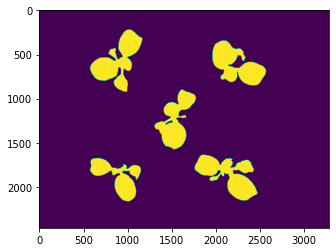

leaf_weight : 59.764


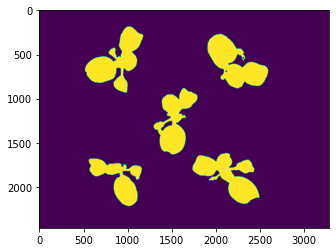

leaf_weight : 72.209


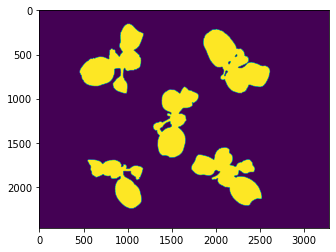

leaf_weight : 85.737


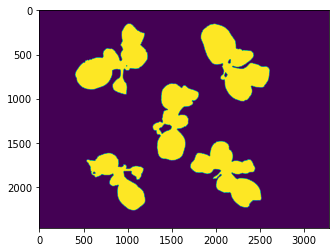

leaf_weight : 102.537


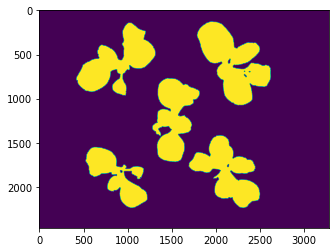

leaf_weight : 123.359


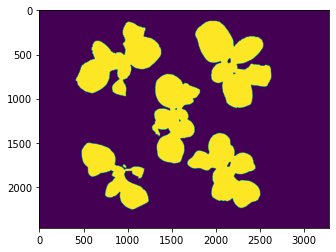

leaf_weight : 156.149


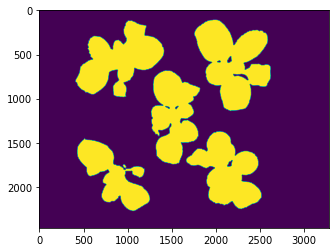

leaf_weight : 174.931


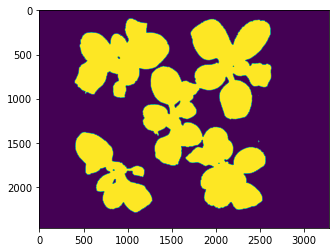

leaf_weight : 187.523


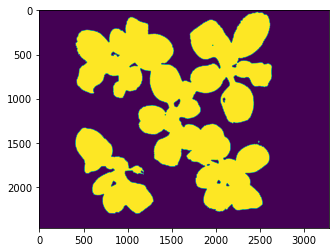

In [13]:
# Test image to see the changes
images = glob(train_cases[0]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[0]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  image_mask = create_mask_for_plant(image)
  # image_segmented = segment_plant(image)
  # image_sharpen = sharpen_image(image_segmented)
  # print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  # axs[0].imshow(image)
  plt.imshow(image_mask)
  # axs[2].imshow(image_segmented)
  # axs[3].imshow(image_sharpen)
  plt.show()

In [14]:
image_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [17]:
len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0]))

0.3338920702011403

In [18]:
metas = glob(train_cases[0]+'/meta/*')
metas_df = pd.concat(map(pd.read_csv, metas), ignore_index=True)

In [19]:
train = pd.DataFrame({'img':[0],'csv':[0],'weight':[0]})
for case in tqdm(train_cases):
  img_train = sorted(glob(case + '/image/*'))
  csv_train = sorted(glob(case + '/meta/*'))
  weights = pd.read_csv(case + '/label.csv')['leaf_weight']
  temp = pd.DataFrame({'img':img_train,'csv':csv_train,'weight':weights})
  train=pd.concat([train,temp], axis=0)
train = train[1:].reset_index(drop=True)
train

  0%|          | 0/75 [00:00<?, ?it/s]

,img,csv,weight
0,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,49.193
1,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,59.764
2,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,72.209
3,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,85.737
4,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,102.537
...,...,...,...
1587,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,211.497
1588,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.116
1589,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.293
1590,/content/drive/MyDrive/KIST/open/train/CASE75/...,/content/drive/MyDrive/KIST/open/train/CASE75/...,210.872


In [56]:
weigth = train['weight']

In [21]:
df_3 = pd.DataFrame()

for row in train['csv']:
  df_1 = pd.read_csv(row)
  df_1 = df_1.drop(['시간'],axis=1)
  df_2 = pd.DataFrame(df_1.mean()).T
  df_3 = df_3.append(df_2)

ParserError: ignored

In [ ]:
temp = []
for row in tqdm(train['img']):
    image = cv2.imread(row)
    image_mask = create_mask_for_plant(image)
    per = len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0]))
    temp.append(per)

df_3['area'] = temp

In [141]:
df_3 = pd.read_csv('/content/drive/MyDrive/df.csv')

In [142]:
df_3['weight'] = train['weight']

In [143]:
# df_3.to_csv('/content/drive/MyDrive/df.csv',index=False)

In [144]:
df_3.columns

Index(['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', 'area', 'weight'],
      dtype='object')

In [145]:
X = df_3[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량','area']]
y = df_3['weight']

In [146]:
X = X.fillna(0)

In [147]:
from sklearn.model_selection import train_test_split

In [148]:
# train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=34)

## area 포함 X

In [134]:
y_train

734       1.800
1174    143.279
537     354.888
422     250.275
315      50.014
         ...   
324       1.093
1109     13.761
490     326.903
1146    119.059
1441      0.951
Name: weight, Length: 1273, dtype: float64

In [135]:
x_train_1 = x_train.drop(['area'],axis=1)
x_valid_1 = x_valid.drop(['area'],axis=1)

In [ ]:
x_train, x_valid, y_train, y_valid

In [149]:
#기본적인 randomforest모형

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score # 정확도 함수

clf = RandomForestRegressor(n_estimators=20, max_depth=5,random_state=0)
clf.fit(x_train_1,y_train)

predict1 = clf.predict(x_valid_1)
clf.score(x_valid_1, y_valid)

0.6369969797798547

In [152]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_valid, predict1)/y_valid.mean()

0.5378933383267109

## Area feature 포함 

In [153]:
clf = RandomForestRegressor(n_estimators=20, max_depth=5,random_state=0)
clf.fit(x_train,y_train)

predict1 = clf.predict(x_valid)
clf.score(x_valid, y_valid)

0.9709935452416788

In [154]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_valid, predict1)/y_valid.mean()

0.08663316669698974

## 상관관계

In [155]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#warning
import warnings
warnings.filterwarnings('ignore')

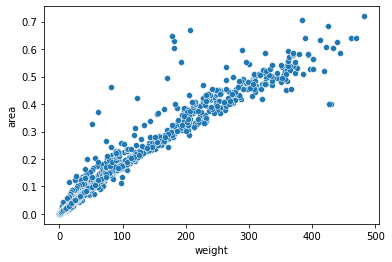

In [160]:
sns.scatterplot(x='weight', y='area', data=df_3)

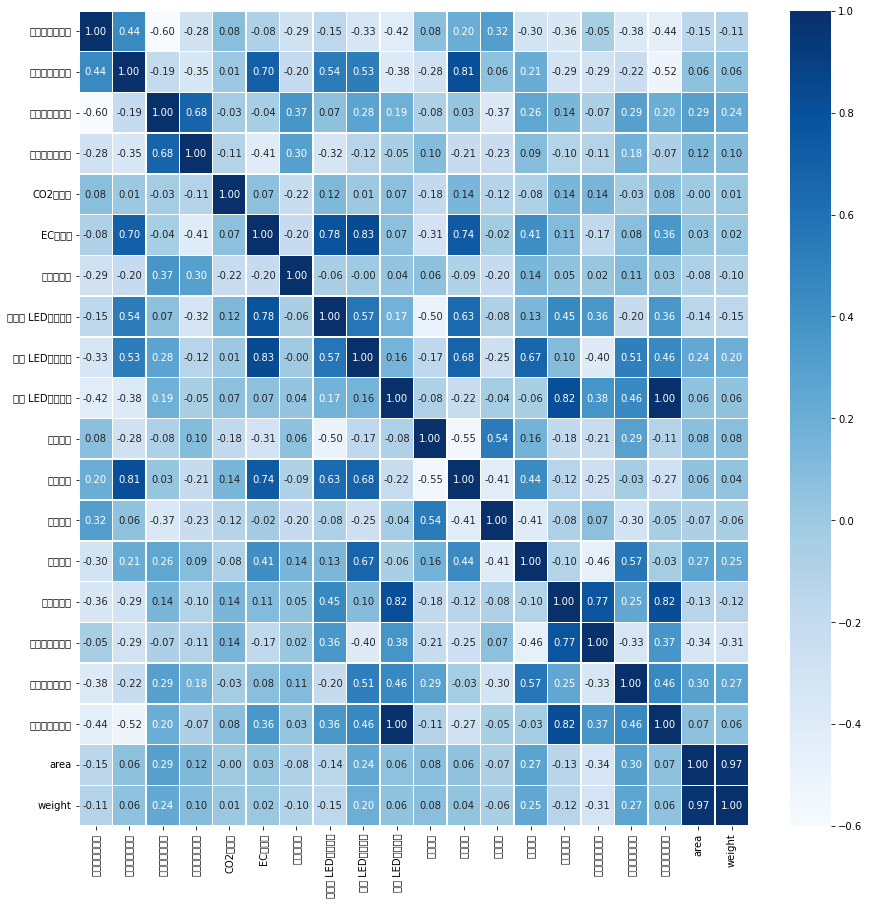

In [159]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_3.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [158]:
df_3.corr()

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area,weight
내부온도관측치,1.000000,0.443830,-0.600650,-0.281603,0.081389,-0.079573,-0.286506,-0.154884,-0.332192,-0.416985,0.075186,0.200705,0.318446,-0.298206,-0.356090,-0.045517,-0.378264,-0.437765,-0.147289,-0.113209
외부온도관측치,0.443830,1.000000,-0.193091,-0.350380,0.007336,0.704130,-0.197434,0.536728,0.526888,-0.379543,-0.278031,0.814504,0.056192,0.206269,-0.294838,-0.291811,-0.219600,-0.516222,0.062333,0.056975
내부습도관측치,-0.600650,-0.193091,1.000000,0.678659,-0.029575,-0.038410,0.370275,0.070190,0.280589,0.185908,-0.078880,0.031523,-0.368498,0.260358,0.141218,-0.074867,0.294144,0.199701,0.294232,0.243121
외부습도관측치,-0.281603,-0.350380,0.678659,1.000000,-0.110769,-0.405291,0.300203,-0.324735,-0.120684,-0.052454,0.099891,-0.205743,-0.225521,0.092333,-0.100582,-0.110194,0.178593,-0.072219,0.121575,0.097891
CO2관측치,0.081389,0.007336,-0.029575,-0.110769,1.000000,0.069596,-0.217075,0.118671,0.011783,0.073177,-0.178147,0.140770,-0.117490,-0.084880,0.138562,0.143870,-0.030911,0.075908,-0.000786,0.013855
EC관측치,-0.079573,0.704130,-0.038410,-0.405291,0.069596,1.000000,-0.197655,0.778466,0.831865,0.069837,-0.305933,0.742780,-0.020758,0.412290,0.111780,-0.170823,0.082002,0.361055,0.033406,0.016123
최근분무량,-0.286506,-0.197434,0.370275,0.300203,-0.217075,-0.197655,1.000000,-0.058155,-0.004221,0.039340,0.064538,-0.088220,-0.197507,0.142976,0.052927,0.020473,0.111881,0.034080,-0.081755,-0.099063
화이트 LED동작강도,-0.154884,0.536728,0.070190,-0.324735,0.118671,0.778466,-0.058155,1.000000,0.569367,0.173412,-0.500552,0.632689,-0.080404,0.133731,0.450134,0.361806,-0.201980,0.363024,-0.144057,-0.150579
레드 LED동작강도,-0.332192,0.526888,0.280589,-0.120684,0.011783,0.831865,-0.004221,0.569367,1.000000,0.158774,-0.166754,0.684655,-0.252427,0.671912,0.097475,-0.396365,0.514576,0.461724,0.237456,0.195653
블루 LED동작강도,-0.416985,-0.379543,0.185908,-0.052454,0.073177,0.069837,0.039340,0.173412,0.158774,1.000000,-0.077692,-0.216406,-0.036224,-0.055626,0.818097,0.376004,0.457844,0.999992,0.057611,0.055769


In [156]:
corr_df = stocks.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

NameError: ignored